# Imports and configs

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
airline_passengers_data_path = "https://storage.googleapis.com/edulabs-public-datasets/airline-passengers.csv"

# Load Data

- Load passengers data as series with datetime index
- set frequency to the index
- check for NaNs and perform interpolation if needed

<Axes: xlabel='Month'>

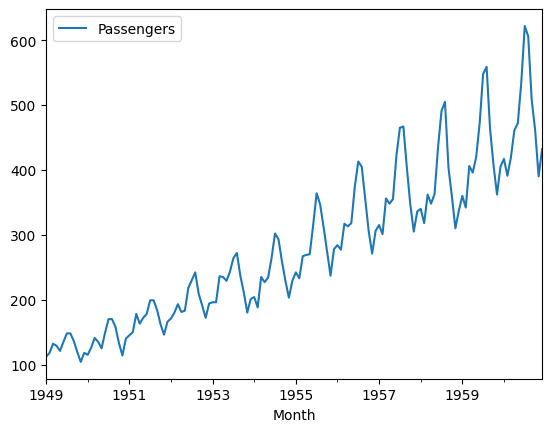

In [3]:
airline_df = pd.read_csv(airline_passengers_data_path, parse_dates=["Month"])
airline_df.set_index("Month", inplace=True)
airline_df.index.freq = "MS"
airline_df.plot()

In [4]:
ts = airline_df.squeeze().interpolate()

In [7]:
ts

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


# Perform hold-out split

- All the data up December 1957 will be for train
- The rest will be for testing

In [8]:
train = ts.loc[:'1957-12']
test = ts.loc['1958-01':]

In [9]:
train.shape, test.shape

((108,), (36,))

# Find ARIMA p, q, d orders

- Use plots and statistical tests to find p, q, d

<Axes: xlabel='Month'>

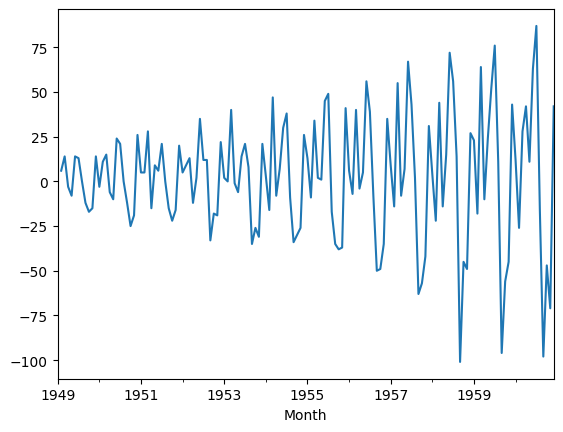

In [10]:
# chacking d
ts.diff().plot()
# looks stationary for d = 1

In [12]:
from statsmodels.tsa.stattools import adfuller
# check stationarity with adf
result = adfuller(ts.diff().dropna())
print(f'p-value: {result[1]}')
# lloks quite stationary (though a bit higher than 0.05
# we'll use d=1)

p-value: 0.05421329028382478


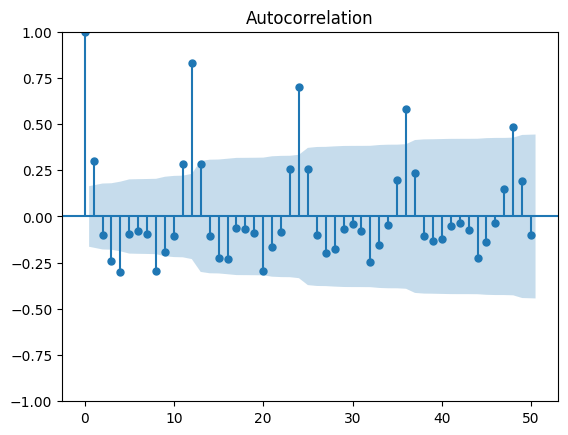

In [14]:
# lets find q (param for MA part)
plot_acf(ts.diff().dropna(), lags=50)
plt.show()
# we see a clear cut-off at q=1, we also observe seasonalities spikes - we'll handle
# them when looking for seasonality P, Q, D
# we'll continue with q=1

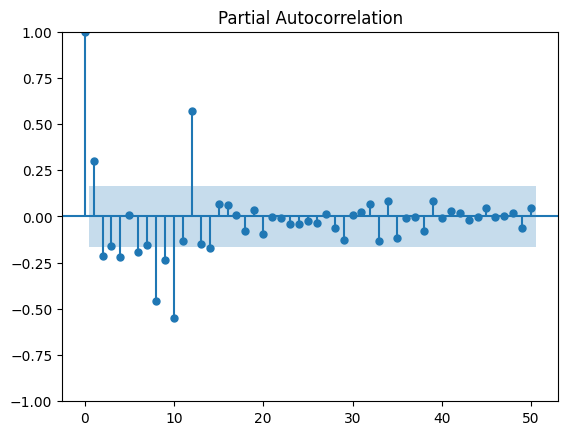

In [15]:
# lets find p param (for the AR part)
plot_pacf(ts.diff().dropna(), lags=50)
plt.show()
# we see clear cutoff at p=1

In [16]:
d = 1
p = 1
q = 1

# Find Seasonal P, Q, D orders

In [17]:
t = ts.diff().dropna()

### Identify the **seasonal period(s)**

Ask: *how often do patterns repeat*?

| Data Type                        | Likely `s` |
| -------------------------------- | ---------- |
| Daily data, weekly seasonality   | 7          |
| Monthly data, yearly seasonality | 12         |
| Hourly data, daily seasonality   | 24         |

If unsure, use **ACF** to look for strong spikes at lags like 7, 12, etc.

---

<Axes: xlabel='Month'>

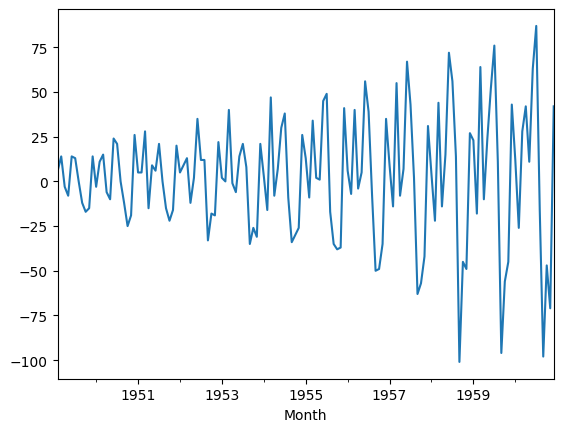

In [21]:
# lets find s parameter (period)
t.plot()
# we clearly see and know that there is yearly seasonality fro this type of data
# so s = 12


### Seasonal **differencing (`D`)**

Check if seasonal differencing is needed:

```python
series.diff(s).plot()  # visually
```


<Axes: xlabel='Month'>

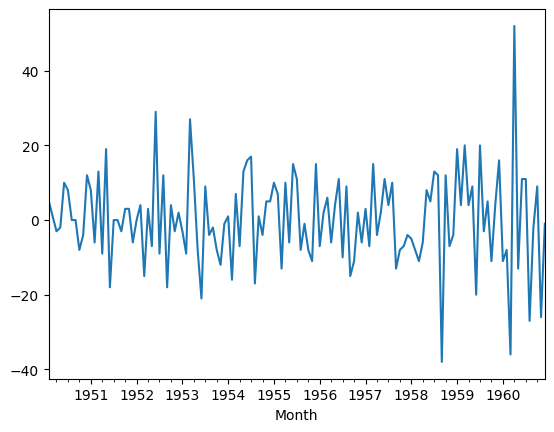

In [22]:
# s = 12
t.diff(12).dropna().plot()
# looks like no clear seasonality left

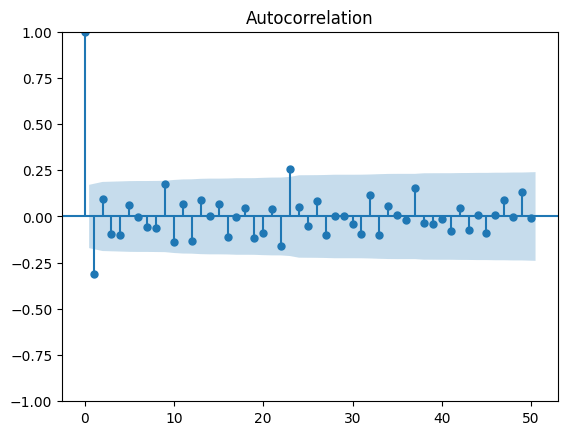

In [28]:
# lets see whether D=1 removes all the seasonality
plot_acf(t.diff(12).dropna(), lags=50)
plt.show()
# no seasonality spikes - D=1 removes seasonality
t = t.diff(12).dropna()

In [27]:
s = 12
D = 1

### Use **seasonal ACF/PACF** to estimate `P` and `Q`

After differencing (if needed), plot ACF/PACF of `seasonally differenced` data:

```python
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(series.diff(s).dropna(), lags=40)
plot_pacf(series.diff(s).dropna(), lags=40)
```

Look for **spikes at seasonal lags** (e.g., 12, 24):

* A **PACF spike at lag `s`** → seasonal AR(1) → `P=1`
* An **ACF spike at lag `s`** → seasonal MA(1) → `Q=1`


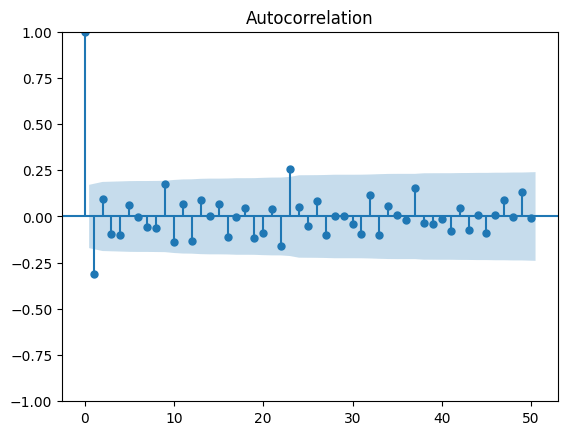

In [31]:
# lets find Q
plot_acf(t, lags=50)
plt.show()
Q = 0

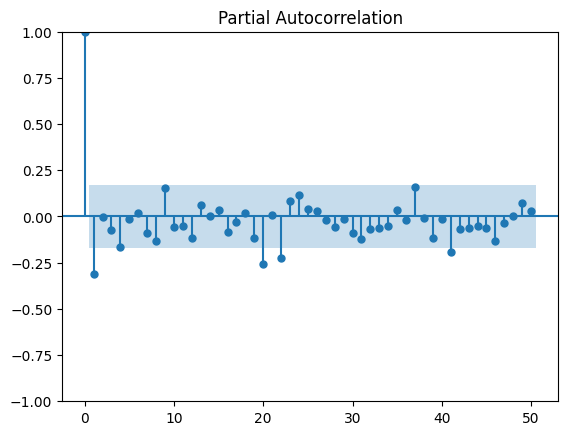

In [32]:
# lets find P
plot_pacf(t, lags=50)
plt.show()
P = 0

### Try combinations and compare AIC/BIC

- Try SARIMAX model
- Use TimeSeriesSplitCV on train data and Grid Search to find the best combination of parameters

```python
SARIMAX(series, order=(p,d,q), seasonal_order=(P,D,Q,s))
```


### 📌 Typical seasonal orders:

| Data                            | Common `(P,D,Q,s)` |
| ------------------------------- | ------------------ |
| Monthly with yearly seasonality | (1,1,1,12)         |
| Daily with weekly seasonality   | (1,1,1,7)          |

---

In [34]:
model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,s))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          Passengers   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -349.541
Date:                             Thu, 15 May 2025   AIC                            705.081
Time:                                     08:23:47   BIC                            712.743
Sample:                                 01-01-1949   HQIC                           708.177
                                      - 12-01-1957                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6085      0.312     -1.953      0.051      -1.219       0.002
ma.L1          0.3968      

In [38]:
# though we are quite sure about our parameters, lets try grid search
# we'll try maybo only seasonal params - P, Q

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import warnings
from sklearn import metrics
warnings.filterwarnings("ignore")



# Candidate parameters
P_values = [0, 1]
D_values = [1, 2]
Q_values = [0, 1]

# CV Setup
tscv = TimeSeriesSplit(n_splits=5)

# Search
best_score = float("inf")
best_order = None

for P in P_values:
    for D in D_values:
        for Q in Q_values:
            mape_list = []
            for train_idx, test_idx in tscv.split(train):
                train_cv, test_cv = ts.iloc[train_idx], ts.iloc[test_idx]
                try:
                    model = SARIMAX(train_cv, order=(p, d, q), seasonal_order=(P,D,Q,s)).fit()
                    forecast = model.forecast(steps=len(test_cv))
                    mape = metrics.mean_absolute_percentage_error(test_cv, forecast)
                    mape_list.append(mape)
                except:
                    break  # Skip failed models
            if len(mape_list) == tscv.get_n_splits():
                avg_mape = np.mean(mape_list)
                print(f"SARIMAX({P},{D},{Q}) MAPE = {avg_mape:.2f}")
                if avg_mape < best_score:
                    best_score = avg_mape
                    best_order = (P, D, Q)

print(f"\n✅ Best order: SARIMAX{best_order} with average MAPE = {best_score:.3f}")


SARIMAX(0,1,0) MAPE = 0.08
SARIMAX(0,1,1) MAPE = 0.09
SARIMAX(0,2,0) MAPE = 0.10
SARIMAX(0,2,1) MAPE = 0.10
SARIMAX(1,1,0) MAPE = 0.09
SARIMAX(1,1,1) MAPE = 0.09
SARIMAX(1,2,0) MAPE = 0.12
SARIMAX(1,2,1) MAPE = 0.11

✅ Best order: SARIMAX(0, 1, 0) with average MAPE = 0.083


As expected, we got best results with our initial params

# Create rolling forecast

- Implement rolling forecast on hold-out (test) data
- Plot actual values vs predictions
- Plot residuals
- Calculate MAE + MAPE for test set



In [39]:
# final model
P = 0
D = 1
Q = 0
p = 1
d = 1
q = 1
s = 12

model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,s))
model_fit = model.fit()


In [41]:
# Rolling Forecast


history = pd.Series(train)
predictions = pd.Series()

for i in test.index:
    model = SARIMAX(history, order=(p,d,q), seasonal_order=(P,D,Q,s))
    model_fit = model.fit()
    yhat = model_fit.predict(start=i, end=i)

    # appending prediciton
    predictions.loc[i] = yhat.loc[i]

    # appending true value
    history.loc[i] = test.loc[i]

fig = go.Figure()
fig.add_trace(go.Scatter(y=history[len(train):], mode='lines+markers', name='Actual'))
fig.add_trace(go.Scatter(y=predictions, mode='lines+markers', name='Predicted'))
fig.update_layout(title='Rolling Forecast', xaxis_title='Date', yaxis_title='Value')
fig.show()


In [47]:
residulas = test - predictions

In [44]:
# prompt: set pandas plotting backend to plotly

import pandas as pd
pd.options.plotting.backend = "plotly"


In [48]:
residulas.plot()

In [50]:
residuals.plot(kind='hist')

In [52]:
print(f'MAE: {metrics.mean_absolute_error(test, predictions)}')
print(f'MAPE: {metrics.mean_absolute_percentage_error(test, predictions)}')

MAE: 12.762253188656372
MAPE: 0.029803035228387106
